# Example of Running `tweakwcs` to Align JWST images

***
## About this Notebook
**Authors:** Mihai Cara, Clare Shanahan (STScI)
<br>**Updated On:** 10/15/2018

This notebooks illustrates how to use tweakwcs to align JWST images. It contains two examples: i) basic/typical alignment of JWST images, and ii) custom workflow using simulated catalogs that allows customization of catalog matching and WCS alignment.

***
## Imports

In [19]:
from astropy.table import Column, Table
from astropy.modeling.models import RotateNative2Celestial
from astropy.coordinates import SkyCoord
from astropy import units as u
from copy import deepcopy
from jwst.datamodels import ImageModel
from jwst.assign_wcs import AssignWcsStep
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from os import path
from photutils import detect_threshold, DAOStarFinder
from tweakwcs import tweak_image_wcs, tweak_wcs, TPMatch, JWSTgWCS

***
## Load Data:

In [20]:
# Load JWST image models:
data_dir = '/grp/jwst/wit/nircam/hilbert/simulated_ramps/image_reg_hack_day/simulated_data/'
im1 = ImageModel(data_dir+'jw98765002001_01106_00001_nrcb1_cal.fits')
im2 = ImageModel(data_dir+'jw98765002001_01105_00001_nrcb1_cal.fits')

# These are test images and so are already perfectly aligned, add a small pointing error to simulate a more 
# realistic scenario. 
im2.meta.wcsinfo.dec_ref += 10.*im2.meta.wcsinfo.cdelt2
im2 = AssignWcsStep.call(im2)

# save a copy of im1's wcs for later use in EXAMPLE 2:
im1_gwcs = deepcopy(im1.meta.wcs)

2018-10-15 16:32:23,548 - stpipe.AssignWcsStep - INFO - AssignWcsStep instance created.
2018-10-15 16:32:23,615 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep running with args (<ImageModel(2048, 2048) from jw98765002001_01105_00001_nrcb1_cal.fits>,).
2018-10-15 16:32:23,906 - stpipe.AssignWcsStep - INFO - Update S_REGION to POLYGON ICRS  53.126305398 -27.805079816 53.123528997 -27.822469535 53.142970172 -27.824976635 53.145949326 -27.807656583
2018-10-15 16:32:23,907 - stpipe.AssignWcsStep - INFO - assign_wcs updated S_REGION to POLYGON ICRS  53.126305398 -27.805079816 53.123528997 -27.822469535 53.142970172 -27.824976635 53.145949326 -27.807656583
2018-10-15 16:32:23,907 - stpipe.AssignWcsStep - INFO - COMPLETED assign_wcs
2018-10-15 16:32:23,914 - stpipe.AssignWcsStep - INFO - Step AssignWcsStep done


***
## EXAMPLE 1: Typical Workflow to Align Two or More Images

First, we will align the two images (the two ImageModels created above) using the most basic workflow. 

This process consists of the following steps.
    1. Detect sources in each image and create source catalogs. 
    2. Insert these catalogs in the ImageModels (in im.meta), where tweakwcs will look for them. 
    3. Inspect the output to verify the alignment
    4. Save the aligned image. 

Note that tweakwcs does not create source catalogs internally, it must be passed in (unlike tweakreg, for those familiar). This increases the flexibility of use - users may generate source catalogs any way they like (segmentation maps, psf fitting, or DAOStarFinder as used here, for example). Users may also apply selection criteria to source catalogs before passing them in. In this example, we simply select all sources detected with DAOStarFinder that are over a certain threshold. 

### 1. Create Source Catalogs

Source catalogs are generated for each image using the DAOStarFinder algorithm in photutils. Once the sources have been detected, the resulting catalog will be added to the image model. 

The source finding parameters in this example have been optimized for this dataset - you may need to tweak these to find sources optimally in your images. 

In [38]:
for catno, im in enumerate([im1, im2]): #iterate over images to create and insert catalogs into imagemodel
    threshold = detect_threshold(im.data, snr=250.)[0, 0]
    daofind = DAOStarFinder(fwhm=5, threshold=threshold)
    cat = daofind(im.data)
    cat.rename_column('xcentroid', 'x')
    cat.rename_column('ycentroid', 'y')
    cat.meta['name'] = 'im{:d} sources'.format(catno); print(len(cat), 'sources detected')
    im.meta['catalog'] = cat 

137 sources detected
127 sources detected


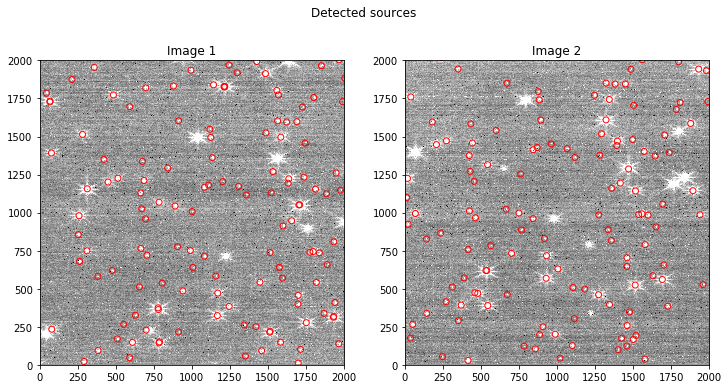

In [39]:
#Plot detected sources 
f, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2,figsize = (12,6)); f.suptitle('Detected sources')
ax1.imshow(im1.data, origin = 'lower', vmin = -0.5, vmax = 0.5, cmap = 'Greys_r')
ax1.scatter(im1.meta['catalog']['x'],im1.meta['catalog']['y'], facecolor = 'None', edgecolor = 'r')
ax1.set_xlim(0,2000); ax1.set_ylim(0,2000); ax1.set_title('Image 1')
ax2.imshow(im2.data, origin = 'lower', vmin = -0.5, vmax = 0.5, cmap = 'Greys_r')
ax2.scatter(im2.meta['catalog']['x'],im2.meta['catalog']['y'], facecolor = 'None', edgecolor = 'r')
ax2.set_xlim(0,2000); ax2.set_ylim(0,2000); ax2.set_title('Image 2'); pass;

### 2. Align Images Using Image Source Catalogs

With source catalogs created and added to each image model, they can now be aligned with tweak_image_wcs.

In [40]:
tweak_image_wcs(images = [im1, im2])

2018-10-15 16:39:24,872 - stpipe - INFO -  
2018-10-15 16:39:24,873 - stpipe - INFO - ***** tweakwcs.imalign.tweak_image_wcs() started on 2018-10-15 16:39:24.872447
2018-10-15 16:39:24,873 - stpipe - INFO -       Version 0.0.0.dev21+g7dbfff7d (2018-10-04 01:03:58 -0400)
2018-10-15 16:39:24,874 - stpipe - INFO -  
2018-10-15 16:39:25,224 - stpipe - INFO - Selected image 'GROUP ID: jw98765002001_01106_00001' as reference image
2018-10-15 16:39:25,229 - stpipe - INFO - Aligning image catalog 'GROUP ID: jw98765002001_01105_00001' to the reference catalog.
2018-10-15 16:39:25,248 - stpipe - INFO - Matching sources from 'Unnamed' catalog with sources from the reference 'Unnamed' catalog.
2018-10-15 16:39:25,248 - stpipe - INFO - Computing initial guess for X and Y shifts...
2018-10-15 16:39:25,249 - stpipe - INFO - Found initial X and Y shifts of -0.02679, -0.008929 with significance of 10.39 and 108.0 matches
2018-10-15 16:39:25,252 - stpipe - INFO - Found 99 matches for 'GROUP ID: jw987650

In [41]:
# save the file:
im2.write('im2_aligned.fits')
#load in the new updated WCS for im2
im2 = ImageModel('im2_aligned.fits')
im2_gwcs = im2.meta.wcs #new, tweaked wcs

### 3. Inspect Corrected WCS. Save Aligned Image.

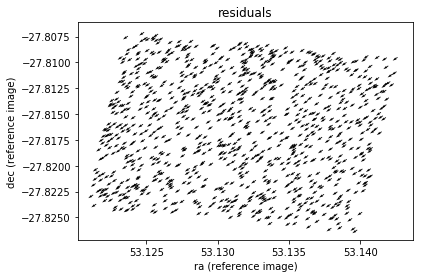

In [42]:
#generate a grid of x,y coordinate positions - we will use the 
x_pix, y_pix = np.random.random(1000) * 2000, np.random.random(1000) * 2000
im1_ra, im1_dec = im1_gwcs(x_pix,y_pix)
im2_ra, im2_dec = im2_gwcs(x_pix,y_pix)

plt.quiver(im1_ra, im1_dec,im1_ra-im2_ra,im1_dec-im2_dec)
plt.title('residuals')
plt.xlabel('ra (reference image)')
plt.ylabel('dec (reference image)'); pass;

***
## EXAMPLE 2: A Customizable Workflow to Align Two Simulated Catalogs

In this example we assume that an image WCS contains errors by generating an image catalog artificially displaced with regard to a perfect reference catalog (obtained using this uncorrected/initial image WCS). We then use `tweakwcs` to find corrections to the image WCS to make the catalogs align.

In [29]:
print(min(np.abs(im1_ra-im2_ra)),max(np.abs(im1_ra-im2_ra)))

0.002644103454727542 0.0026462884699753886


In [31]:
print(im2.meta.wcs)

  From              Transform           
-------- -------------------------------
detector                CompoundModel617
    v2v3 tangent-plane linear correction
v2v3corr                CompoundModel619
   world                            None


In [32]:
print(im1.meta.wcs)

  From      Transform    
-------- ----------------
detector CompoundModel488
    v2v3 CompoundModel490
   world             None


### 1. Generate Reference Catalog

In [ ]:
ny, nx = im1.data.shape

# generate random sources in im1 detector:
rcx = Column(data=np.random.randint(0, nx, 30), name='x', dtype=np.float)
rcy = Column(data=np.random.randint(0, ny, 30), name='y', dtype=np.float)

# convert image coordinates to sky coords:
ra, dec = im1_gwcs(rcx, rcy)
rra = Column(data=ra, name='RA', dtype=np.float)
rdec = Column(data=dec, name='DEC', dtype=np.float)

# create the catalog:
refcat = Table([rra, rdec])
refcat.meta['name'] = 'REFCAT'

### 2. Create Image Catalog

We take the reference catalog and apply small Euler rotations to sky positions. This "displaced" catalog now will serve as an image catalog that we will try to align back to the reference catalog and find the correction that needs to be applied to the "image's WCS" to make image catalog align to the reference catalog. Essentially, here we simulate an image source catalog as if these sources were detected in image `im2` having the WCS from `im1.meta.wcs`.

In [ ]:
# Apply small Euler rotations to the reference source coordinates:
m = RotateNative2Celestial(5.0e-05, 90, 180)
ra_displ, dec_displ = m(ra, dec)

# convert sky coordinates to image coordinates using initial/reference image WCS:
x_displ, y_displ = im1_gwcs.invert(ra_displ, dec_displ)

# remove sources outside the detector:
mask = (x_displ > 0) & (x_displ < nx) & (y_displ > 0) & (y_displ < ny)
x_displ = x_displ[mask]
y_displ = y_displ[mask]

# Create image catalog also randomizing source order:
imcat = Table([x_displ, y_displ], names=['x', 'y'])
imcat.meta['name'] = 'IMCAT'

### 3. Create a telescope/instrument-specific "corrector" WCS object

In [ ]:
# create JWST-specific TPWCS object using the WCS that needs to be corrected:
wcsinfo = im1.meta.wcsinfo._instance
imwcs = JWSTgWCS(wcs=im1_gwcs, wcsinfo=wcsinfo)

### 4. Find Indices of Matched Sources

In [ ]:
# Match sources in the catalogs:
match = TPMatch(searchrad=5, separation=0.1, tolerance=5, use2dhist=False)
ridx, iidx = match(refcat, imcat, imwcs)

### 5. Align Images:

In [ ]:
tweaked_tpwcs = tweak_wcs(refcat[ridx], imcat[iidx], imwcs)
corrected_wcs = tweaked_tpwcs.wcs

### 6. Check alignment
This can be done, for example, by comparing reference catalog's sky coordinates with the sky coordinates of the same sources obtained using corrected WCS from "image" catalog.

In [ ]:
# Use aligned WCS to compute new sky coordinates of sources from the "image" catalog:
ra_aligned, dec_aligned = corrected_wcs(x_displ[iidx], y_displ[iidx])
img_sky_coords = SkyCoord(ra_aligned * u.deg, dec_aligned * u.deg, frame='icrs')

# Compare with reference catalog source positions:
ref_sky_coords = SkyCoord(ra[ridx] * u.deg, dec[ridx] * u.deg, frame='icrs')

# Find maximum error:
print(np.amax(ref_sky_coords.separation(img_sky_coords).to(u.marcsec)))

### 7. Inspect Corrected WCS. Save Aligned Image.

In [ ]:
# inspect WCS Tangent-Plane Corrections
for f, p in corrected_wcs.pipeline:
    if f == 'v2v3':
        print(p.__repr__())
        break

# assign tweaked WCS as model's WCS:
im2.meta.wcs = corrected_wcs

# save the file:
im2.write('im2_aligned.fits')